 ### 比赛思路：分别采用两种数据处理做融合， 第一种：基于baseline处理逻辑，其中每日各个时刻的数据是打乱的；第二种：保持每日内各个时刻数据是连续的，并且保证同一日的数据不会同时存在训练集和验证集中。

In [36]:
from pathlib import Path
import itertools

import pandas as pd
import numpy as np
from tqdm import tqdm
import lightgbm as lgb
import xgboost as xgb
import warnings
import seaborn as sns
from sklearn.model_selection import KFold
from sklearn.decomposition import PCA
from sklearn.metrics import mean_absolute_error

import matplotlib.pyplot as plt


warnings.filterwarnings('ignore')

# pandas options
PD_MAX_ROWS = 100
PD_MAX_COLUMNS = 500
PD_WIDTH = 500
PD_MAX_COL_WIDTH = 500
pd.set_option('display.max_rows', PD_MAX_ROWS)
pd.set_option('display.max_columns', PD_MAX_COLUMNS)
pd.set_option('display.width', PD_WIDTH)
pd.set_option('display.max_colwidth', PD_MAX_COL_WIDTH)

# seaborn settings constants
# SNS_STYLE = 'darkgrid'
SNS_FIG_SIZE = (10, 6)
#sns.set_style(SNS_STYLE)
sns.set({"figure.figsize": SNS_FIG_SIZE})
#color_pal = sns.color_palette()

#plt.style.use('fivethirtyeight')

## 1. EDA

In [27]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('preliminary_A.csv')

In [28]:
train_df.describe()

,month,is_weekend,L1,L2,L3,L4,L5,L6,y
count,38400.000000,38400.000000,38400.000000,38400.000000,38400.000000,38400.000000,38400.000000,38400.000000,38400.000000
mean,6.572500,0.266250,21.769053,23.429187,-0.170735,5.213793,4.443845,-0.623873,19.805241
std,3.488203,0.442002,17.092855,22.083805,5.470104,5.406456,4.934397,4.493714,12.141615
min,1.000000,0.000000,-21.835400,-24.661300,-13.933500,-9.884400,-6.607400,-31.462000,-4.150000
25%,3.000000,0.000000,8.640500,5.916600,-3.619825,0.938200,0.604100,-1.126700,10.270600
50%,7.000000,0.000000,16.075400,12.473250,2.360600,3.550400,2.613600,0.533200,17.275400
75%,10.000000,1.000000,36.564700,41.056650,3.294400,8.963100,9.100900,1.081600,28.842825
max,12.000000,1.000000,103.914500,90.362200,16.951700,31.999600,25.706600,2.932100,58.327600


<AxesSubplot:>

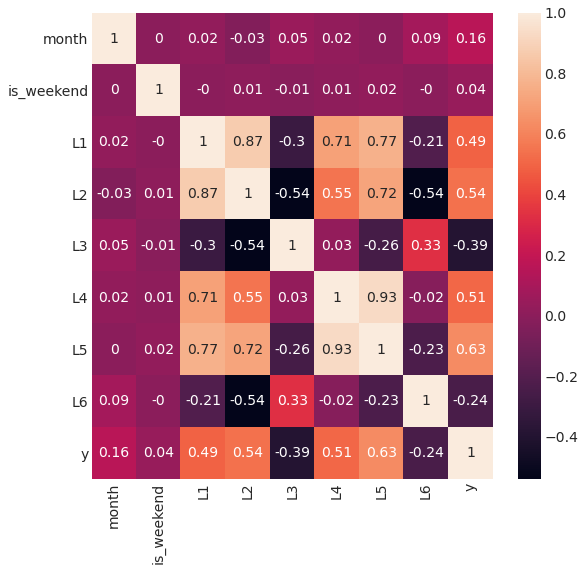

In [29]:
# 设置大小
plt.subplots(figsize=(8, 8))
# 热力图
# annot=True 显示数值
# round(2) 小数点2位
sns.heatmap(train_df.corr().round(2),annot=True)

<AxesSubplot:xlabel='month', ylabel='y'>

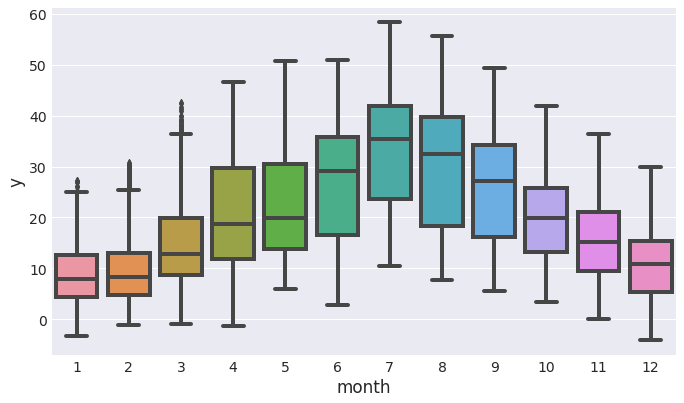

In [32]:
sns.boxplot(y=train_df['y'],x=train_df['month'])

<AxesSubplot:xlabel='time', ylabel='y'>

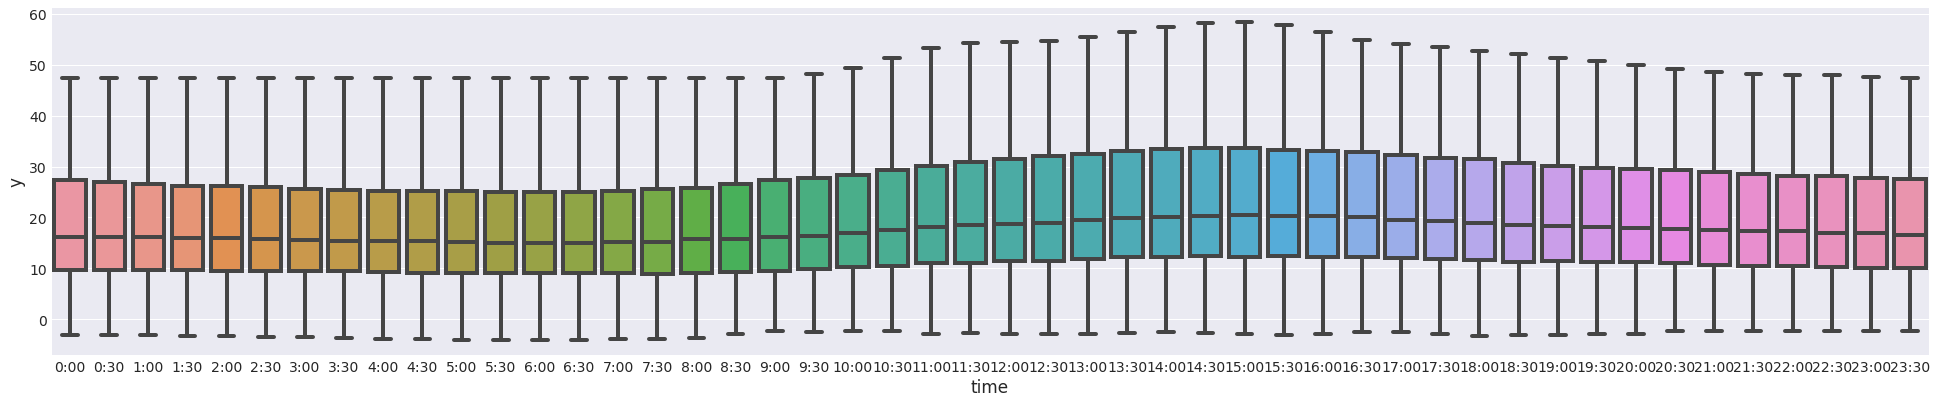

In [38]:

SNS_FIG_SIZE = (30, 6)
#sns.set_style(SNS_STYLE)
sns.set({"figure.figsize": SNS_FIG_SIZE})
sns.boxplot(y=train_df['y'],x=train_df['time'])

 ## 数据分析：可以看到label y和L1-L6特征相关度还是比较高的，同时也能看出y和month、time等时间特征关联性比较强，由于date_id是不连续的，没法采用时间序列的处理方式。但是加入从时间信息、L1-L6衍生的特征后，分数几乎没有变化。

## 2.方案融合： 第一种数据处理方式，代码主体参考baseline，不过在A榜提交测试过程中发现，删去baseline中生成的数据特征会有一定的分数提升。

In [42]:
# 构建小时 季节 滞后 滑动特征
def time_span(t):
    if t >= 0 and t < 5:
        return 0
    elif t >= 5 and t < 8:
        return 1
    elif t >= 8 and t < 11:
        return 2
    elif t >= 11 and t < 13:
        return 3
    elif t >= 13 and t < 16:
        return 4
    elif t >= 16 and t < 19:
        return 5
    elif t >= 19 and t < 24:
        return 6


def get_season_from_month(month):
    if 1 <= month < 4:
        r = 1
    elif 4 <= month < 7:
        r = 2
    elif 7 <= month < 10:
        r = 3
    else:
        r = 4
    return r

def get_lat_feature(df):
    tmp_res = pd.DataFrame()
    for i, data in df.groupby(['date_id', 'transformers']):
        tmp1 = data['L1'].shift()
        tmp2 = data['L2'].shift()
        tmp3 = data['L3'].shift()
        tmp4 = data['L4'].shift()
        tmp5 = data['L5'].shift()
        tmp6 = data['L6'].shift()

        tmp = pd.concat([tmp1, tmp2, tmp3, tmp4, tmp5, tmp6], axis=1)
        tmp.columns = ['last_time_l1', 'last_time_l2', 'last_time_l3', 'last_time_l4', 'last_time_l5', 'last_time_l6']
        tmp_res = pd.concat([tmp_res, tmp])

    df = pd.concat([df, tmp_res], axis=1)

    cols = ['last_time_l1', 'last_time_l2', 'last_time_l3', 'last_time_l4', 'last_time_l5', 'last_time_l6']

    for col in cols:
        df[col] = df[col].fillna(method='bfill')

    return df


def get_rolling_feature(df):
    tmp_res = pd.DataFrame()
    for i, data in df.groupby(['date_id', 'transformers']):
        tmp1 = data['L1'].rolling(35, min_periods=1).mean()
        tmp2 = data['L2'].rolling(35, min_periods=1).mean()
        tmp3 = data['L3'].rolling(35, min_periods=1).mean()
        tmp4 = data['L4'].rolling(35, min_periods=1).mean()
        tmp5 = data['L5'].rolling(35, min_periods=1).mean()
        tmp6 = data['L6'].rolling(35, min_periods=1).mean()

        tmp = pd.concat([tmp1, tmp2, tmp3, tmp4, tmp5, tmp6], axis=1)
        tmp.columns = ['roll_l1', 'roll_l2', 'roll_l3', 'roll_l4', 'roll_l5', 'roll_l6']
        tmp_res = pd.concat([tmp_res, tmp])

    df = pd.concat([df, tmp_res], axis=1)

    return df


In [43]:

train_df['hour'] = train_df['time'].apply(lambda x: int(x.split(':')[0]))
train_df['time_span'] = train_df['hour'].apply(time_span)

test_df['hour'] = test_df['time'].apply(lambda x: int(x.split(':')[0]))
test_df['time_span'] = test_df['hour'].apply(time_span)

train_df['season'] = train_df['month'].apply(lambda x: get_season_from_month(x))
test_df['season'] = test_df['month'].apply(lambda x: get_season_from_month(x))

In [44]:
# 构建不同时间与变压器油温的关系
for f in [
    ['month'], ['time'], ['hour'], ['time_span'], ['season'],
    ['transformers', 'month'], ['transformers', 'time'], ['transformers', 'hour'], ['transformers', 'time_span'],['transformers', 'season'],
    ['transformers', 'is_weekend', 'month'], ['transformers', 'is_weekend', 'time'],['transformers', 'is_weekend', 'season'],
    ['transformers', 'is_weekend', 'hour'], ['transformers', 'is_weekend', 'time_span']
]:
    print('------------------ {} ------------------'.format('_'.join(f)))
    folds = KFold(n_splits=5, shuffle=True, random_state=2023)

    train_df['fold'] = None
    for fold_, (trn_idx, val_idx) in enumerate(folds.split(train_df, train_df)):
        train_df.loc[val_idx, 'fold'] = fold_

    colname = '_'.join(f) + '_y_mean'

    if len(f) == 1:
        feat = f[0]
    elif len(f) == 2:
        train_df['_'.join(f)] = train_df[f[0]].astype(str) + '_' + train_df[f[1]].astype(str)
        test_df['_'.join(f)] = test_df[f[0]].astype(str) + '_' + test_df[f[1]].astype(str)
        feat = '_'.join(f)
    elif len(f) == 3:
        train_df['_'.join(f)] = train_df[f[0]].astype(str) + '_' + train_df[f[1]].astype(str) + '_' + train_df[
            f[2]].astype(str)
        test_df['_'.join(f)] = test_df[f[0]].astype(str) + '_' + test_df[f[1]].astype(str) + '_' + test_df[f[2]].astype(
            str)
        feat = '_'.join(f)

    # train
    train_df[colname] = None
    for fold_, (trn_idx, val_idx) in enumerate(folds.split(train_df, train_df)):
        Log_trn = train_df.iloc[trn_idx]

        order_label = Log_trn.groupby([feat])['y'].mean()
        tmp_df = train_df.loc[train_df.fold == fold_, [feat]]
        train_df.loc[train_df.fold == fold_, colname] = tmp_df[feat].map(order_label)

    # test
    test_df[colname] = None
    order_label = train_df.groupby([feat])['y'].mean()
    test_df[colname] = test_df[feat].map(order_label)

    if len(f) != 1:
        del train_df['_'.join(f)], test_df['_'.join(f)]


------------------ month ------------------
------------------ time ------------------
------------------ hour ------------------
------------------ time_span ------------------
------------------ season ------------------
------------------ transformers_month ------------------
------------------ transformers_time ------------------
------------------ transformers_hour ------------------
------------------ transformers_time_span ------------------
------------------ transformers_season ------------------
------------------ transformers_is_weekend_month ------------------
------------------ transformers_is_weekend_time ------------------
------------------ transformers_is_weekend_season ------------------
------------------ transformers_is_weekend_hour ------------------
------------------ transformers_is_weekend_time_span ------------------


In [45]:
# 自然数编码
train_df['transformers'] = train_df['transformers'].map({'M1': 1, 'M2': 2})
test_df['transformers'] = test_df['transformers'].map({'M1': 1, 'M2': 2})
# 转换为了0-47的整数
train_df['time'] = train_df['time'].apply(lambda x: int(x.split(':')[0]) * 2 + int(x.split(':')[1]) // 30)
test_df['time'] = test_df['time'].apply(lambda x: int(x.split(':')[0]) * 2 + int(x.split(':')[1]) // 30)

train_df = get_lat_feature(train_df)
test_df = get_lat_feature(test_df)

train_df = get_rolling_feature(train_df)
test_df = get_rolling_feature(test_df)

In [46]:
# 划分 m1m2
train_df_m1 = train_df[train_df['transformers'] == 1]
test_df_m1 = test_df[test_df['transformers'] == 1]

train_df_m2 = (train_df[train_df['transformers'] == 2]).reset_index()
test_df_m2 = test_df[test_df['transformers'] == 2].reset_index()

In [47]:
# 入模特征列， 这里其实删除了baseline构建的特征
cols = [f for f in train_df.columns if f not in ['id', 'date_id', 'y', 'fold',
                                                 'transformers', 'time_y_mean', 'hour_y_mean',
                                                 'time_span_y_mean','transformers_month_y_mean',
                                                 'transformers_time_y_mean', 'transformers_hour_y_mean',
                                                 'transformers_time_span_y_mean',
                                                 'transformers_is_weekend_month_y_mean',
                                                 'transformers_is_weekend_time_y_mean',
                                                 'transformers_is_weekend_hour_y_mean',
                                                 'transformers_is_weekend_time_span_y_mean',
                                                 'month_y_mean', 'season_y_mean', 'season',
                                                 'transformers_season_y_mean', 'transformers_is_weekend_season_y_mean',
                                                 'time_span']]

In [48]:
# M1 M2各自训练LGB model
def cv_model_m1(clf, train_x, train_y, test_x, seed=2023):
    kf = KFold(n_splits=5, shuffle=True, random_state=seed)
    pred = np.zeros(test_x.shape[0])
    for i, (train_index, valid_index) in enumerate(kf.split(train_x, train_y)):
        print('************************************ {} {}************************************'.format(str(i + 1),
                                                                                                      str(seed)))
        trn_x, trn_y, val_x, val_y = train_x.iloc[train_index], train_y[train_index], train_x.iloc[valid_index], \
                                     train_y[valid_index]


        train_matrix = clf.Dataset(trn_x, label=trn_y)
        valid_matrix = clf.Dataset(val_x, label=val_y)

        params = {
            'boosting_type': 'gbdt',
            'objective': 'regression',
            'metric': 'mae',
            'num_leaves': 63,
            'feature_fraction': 0.8,
            'bagging_fraction': 0.8,
            'learning_rate': 0.02,
            'seed': seed,
            'n_jobs': 16,
            'verbose': -1,
            'reg_lambda': 5,
            'reg_alpha': 2,
        }

        model = clf.train(params, train_matrix, 15000, valid_sets=[train_matrix, valid_matrix],
                          verbose_eval=500, early_stopping_rounds=500)


        test_pred = model.predict(test_x, num_iteration=model.best_iteration)
     
        pred += test_pred / kf.n_splits
        # 计算pred

    return pred


def cv_model_m2(clf, train_x, train_y, test_x, seed=2023):
    kf = KFold(n_splits=5, shuffle=True, random_state=seed)

    pred = np.zeros(test_x.shape[0])

    for i, (train_index, valid_index) in enumerate(kf.split(train_x, train_y)):
        print('************************************ {} {}************************************'.format(str(i + 1),
                                                                                                      str(seed)))
        trn_x, trn_y, val_x, val_y = train_x.iloc[train_index], train_y[train_index], train_x.iloc[valid_index], \
                                     train_y[valid_index]

        train_matrix = clf.Dataset(trn_x, label=trn_y)
        valid_matrix = clf.Dataset(val_x, label=val_y)

        params = {
            'boosting_type': 'gbdt',
            'objective': 'regression',
            'metric': 'mae',
            'num_leaves': 63,
            'feature_fraction': 0.8,
            'bagging_fraction': 0.8,
            'learning_rate': 0.02,
            'seed': seed,
            'n_jobs': 16,
            'verbose': -1,
            'reg_lambda': 5,
            'reg_alpha': 2
        }

        model = clf.train(params, train_matrix, 15000, valid_sets=[train_matrix, valid_matrix],
                          verbose_eval=500, early_stopping_rounds=500)
        test_pred = model.predict(test_x, num_iteration=model.best_iteration)

        pred += test_pred / kf.n_splits

    return pred

In [ ]:
#  分模型
print('**********************M1*******************************')
lgb_pred_m1 = cv_model_m1(lgb, train_df_m1[cols].astype(float), train_df_m1['y'], test_df_m1[cols].astype(float))
print('**********************M2*******************************')
lgb_pred_m2 = cv_model_m2(lgb, train_df_m2[cols].astype(float), train_df_m2['y'], test_df_m2[cols].astype(float))


# 提交结果，得到方法1的submit
test_df['y'] = np.append(lgb_pred_m1, lgb_pred_m2)
test_df[['id','y']].to_csv('submit.csv', index=False)

## 方案融合： 第二种数据处理方式

In [2]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('preliminary_A.csv')
test_df2 = pd.read_csv("preliminary_B.csv")
test_df = pd.concat([test_df, test_df2])
concat_df = pd.concat([train_df, test_df])

In [3]:
concat_df.head()

,id,transformers,date_id,month,is_weekend,time,L1,L2,L3,L4,L5,L6,y
0,M1_D00003_00_00,M1,D00003,4,0,0:00,16.4772,11.6558,4.4320,6.4635,4.3713,1.1885,9.7434
1,M1_D00003_00_30,M1,D00003,4,0,0:30,16.2091,11.8867,4.4020,6.4640,4.6197,1.1879,9.9550
2,M1_D00003_01_00,M1,D00003,4,0,1:00,15.9085,11.5495,4.3407,6.5308,4.0870,1.1272,10.1302
3,M1_D00003_01_30,M1,D00003,4,0,1:30,15.7744,11.3179,4.2491,6.0959,4.1756,1.0818,10.5524
4,M1_D00003_02_00,M1,D00003,4,0,2:00,15.6739,11.4603,4.3714,6.6315,4.2463,1.1573,10.3770


In [4]:
concat_df['time_id'] = concat_df['time'].apply(lambda x:int(x.split(':')[0])*2 + int(x.split(':')[1])//30)
concat_df['season'] = concat_df['month'].apply(lambda x: x // 3)

In [5]:
# 拿到L特征的前2个数据和后一个数据
def find_lxb(row):
    trans_id = row['transformers']
    date_id = row['date_id']
    time_id = row['time_id']
    row_1 = concat_df.query(f'transformers == "{trans_id}" and date_id == "{date_id}" and time_id == {max(0, time_id - 1)}')
    row_2 = concat_df.query(f'transformers == "{trans_id}" and date_id == "{date_id}" and time_id == {max(0, time_id - 2)}')
    row_3 = concat_df.query(f'transformers == "{trans_id}" and date_id == "{date_id}" and time_id == {min(47, time_id + 1)}')
    
    data_0 = row.loc[['L1', 'L2', 'L3', 'L4', 'L5', 'L6']]
    data_1 = row_1.iloc[0].loc[['L1', 'L2', 'L3', 'L4', 'L5', 'L6']]
    data_2 = row_2.iloc[0].loc[['L1', 'L2', 'L3', 'L4', 'L5', 'L6']]
    data_3 = row_3.iloc[0].loc[['L1', 'L2', 'L3', 'L4', 'L5', 'L6']]

    data_1.columns = ['L1b', 'L2b', 'L3b', 'L4b', 'L5b', 'L6b']
    data_2.columns = ['L1bb', 'L2bb', 'L3bb', 'L4bb', 'L5bb', 'L6bb']
    data_3.columns = ['L1a', 'L2a', 'L3a', 'L4a', 'L5a', 'L6a']

    return pd.concat([data_0, data_1, data_2, data_3], ignore_index=True)

In [6]:
if Path('extend_f.csv').exists():
    extend_f = pd.read_csv('extend_f.csv')
else:
    extend_f = concat_df.apply(find_lxb, axis=1)
    extend_f.to_csv('extend_f.csv', index_label=False)
extend_f.columns = ['L1', 'L2', 'L3', 'L4', 'L5', 'L6', 'L1b', 'L2b', 'L3b', 'L4b', 'L5b', 'L6b', 'L1bb', 'L2bb', 'L3bb', 'L4bb', 'L5bb', 'L6bb', 'L1a', 'L2a', 'L3a', 'L4a', 'L5a', 'L6a']

In [7]:
# PCA降维
pca = PCA(n_components=4)
pca.fit(extend_f[['L1b', 'L2b', 'L3b', 'L4b', 'L5b', 'L6b', 'L1bb', 'L2bb', 'L3bb', 'L4bb', 'L5bb', 'L6bb', 'L1a', 'L2a', 'L3a', 'L4a', 'L5a', 'L6a']])

PCA(n_components=4)

In [8]:
b_df = pca.transform(extend_f[['L1b', 'L2b', 'L3b', 'L4b', 'L5b', 'L6b', 'L1bb', 'L2bb', 'L3bb', 'L4bb', 'L5bb', 'L6bb', 'L1a', 'L2a', 'L3a', 'L4a', 'L5a', 'L6a']])

In [9]:
b_df = pd.DataFrame(b_df)
b_df.columns = ['B1', 'B2', 'B3', 'B4']

In [10]:
b_df.reset_index(inplace=True)
extend_f.reset_index(inplace=True)
concat_df.reset_index(inplace=True)

In [11]:
# L特征处理
extend_f['L1d'] = extend_f['L1b'] - extend_f['L1']
extend_f['L2d'] = extend_f['L2b'] - extend_f['L2']
extend_f['L3d'] = extend_f['L3b'] - extend_f['L3']
extend_f['L4d'] = extend_f['L4b'] - extend_f['L4']
extend_f['L5d'] = extend_f['L5b'] - extend_f['L5']
extend_f['L6d'] = extend_f['L6b'] - extend_f['L6']

extend_f['L1m'] = extend_f['L1b'] + extend_f['L1bb'] + extend_f['L1a']
extend_f['L2m'] = extend_f['L2b'] + extend_f['L2bb'] + extend_f['L2a']
extend_f['L3m'] = extend_f['L3b'] + extend_f['L3bb'] + extend_f['L3a']
extend_f['L4m'] = extend_f['L4b'] + extend_f['L4bb'] + extend_f['L4a']
extend_f['L5m'] = extend_f['L5b'] + extend_f['L5bb'] + extend_f['L5a']
extend_f['L6m'] = extend_f['L6b'] + extend_f['L6bb'] + extend_f['L6a']

b_df = pd.concat([b_df, extend_f[['L1d', 'L2d', 'L3d', 'L4d', 'L5d', 'L6d', 'L1m', 'L2m', 'L3m', 'L4m', 'L5m', 'L6m']]], axis=1)

In [12]:
concat_df_extended = pd.concat([concat_df, b_df], axis=1)

In [13]:
train_length = len(train_df)
train_df = concat_df_extended.iloc[:train_length]
test_df = concat_df_extended.iloc[train_length:]

In [14]:
def time_span(t):
    return t // 3

train_df['hour'] = train_df['time'].apply(lambda x:int(x.split(':')[0]))
train_df['time_span'] = train_df['hour'].apply(time_span)

test_df['hour'] = test_df['time'].apply(lambda x:int(x.split(':')[0]))
test_df['time_span'] = test_df['hour'].apply(time_span)

In [15]:
train_df_M1 = train_df.query('transformers == "M1"')
test_df_M1 = test_df.query('transformers == "M1"')
train_df_M2 = train_df.query('transformers == "M2"')
test_df_M2 = test_df.query('transformers == "M2"')

In [16]:
for f in [
    ['month'], ['time'], ['hour'], ['time_span'],['season'],
    ['is_weekend', 'month'], ['is_weekend', 'time'], ['is_weekend', 'hour'], ['is_weekend', 'time_span'],['is_weekend', 'season']
]:
    col_name = '.'.join(f) + "_mean"
    
    if len(f) == 1:
        feature_name = f[0]
    elif len(f) == 2:
        feature_name = '_'.join(f)
        train_df_M1[feature_name] = train_df_M1[f[0]].astype(str) + '_' + train_df_M1[f[1]].astype(str)
        test_df_M1[feature_name] = test_df_M1[f[0]].astype(str) + '_' + test_df_M1[f[1]].astype(str)
        train_df_M2[feature_name] = train_df_M2[f[0]].astype(str) + '_' + train_df_M2[f[1]].astype(str)
        test_df_M2[feature_name] = test_df_M2[f[0]].astype(str) + '_' + test_df_M2[f[1]].astype(str)

    
    order_label_M1 = train_df_M1.groupby([feature_name])['y'].mean()
    order_label_M2 = train_df_M2.groupby([feature_name])['y'].mean()

    train_df_M1[col_name] = train_df_M1[feature_name].map(order_label_M1)
    test_df_M1[col_name] = test_df_M1[feature_name].map(order_label_M1)
    
    train_df_M2[col_name] = train_df_M2[feature_name].map(order_label_M2)
    test_df_M2[col_name] = test_df_M2[feature_name].map(order_label_M2)
    
    if len(f) > 1:
        del train_df_M1[feature_name], test_df_M1[feature_name]
        del train_df_M2[feature_name], test_df_M2[feature_name]

In [17]:
# 连续特征分桶
for f in ['L1', 'L2', 'L3', 'L4', 'L5', 'L6', 'B1', 'B2', 'B3', 'B4']:
    cut_name = f + '_cut'
    col_name = f + '_cut_mean'
    M1_all = pd.concat([train_df_M1, test_df_M1])
    M2_all = pd.concat([train_df_M2, test_df_M2])
    
    M1_all[cut_name] = pd.cut(M1_all[f], 6)
    M2_all[cut_name] = pd.cut(M2_all[f], 6)
    
    order_label_M1 = M1_all.iloc[:len(train_df_M1)].groupby(cut_name)['y'].mean()
    order_label_M2 = M2_all.iloc[:len(train_df_M2)].groupby(cut_name)['y'].mean()
    
    train_df_M1[col_name] = M1_all.iloc[:len(train_df_M1)][cut_name].map(order_label_M1).astype('float')
    train_df_M2[col_name] = M2_all.iloc[:len(train_df_M2)][cut_name].map(order_label_M2).astype('float')
    
    test_df_M1[col_name] = M1_all.iloc[len(train_df_M1):][cut_name].map(order_label_M1).astype('float')
    test_df_M2[col_name] = M2_all.iloc[len(train_df_M2):][cut_name].map(order_label_M2).astype('float')

In [18]:
train_df = pd.concat([train_df_M1, train_df_M2])
test_df = pd.concat([test_df_M1, test_df_M2])

In [20]:
# 构造额外交叉特征
ori_cols = ['L1', 'L2', 'L3', 'L4', 'L5', 'L6']
ext_cols = ['B1', 'B2', 'B3', 'B4']

for ori_col in ori_cols:
    for ext_col in ext_cols:
        train_df[f'{ori_col}_{ext_col}'] = train_df[ori_col] / (train_df[ext_col] + 0.01)
        test_df[f'{ori_col}_{ext_col}'] = test_df[ori_col] / (test_df[ext_col] + 0.01)
for com_cols in itertools.combinations(ori_cols, 2):
    train_df[f'{com_cols[0]}_{com_cols[1]}'] = (train_df[f'{com_cols[0]}'] + 1) / (train_df[f'{com_cols[1]}'] + 0.01)
    test_df[f'{com_cols[0]}_{com_cols[1]}'] = (test_df[f'{com_cols[0]}'] + 1 ) / (test_df[f'{com_cols[1]}'] + 0.01)
    train_df[f'{com_cols[0]}+{com_cols[1]}'] = (train_df[f'{com_cols[0]}'] + 1) + (train_df[f'{com_cols[1]}'])
    test_df[f'{com_cols[0]}+{com_cols[1]}'] = (test_df[f'{com_cols[0]}'] + 1 ) + (test_df[f'{com_cols[1]}'])

In [21]:
cols = [f for f in train_df.columns if f not in ['transformers', 'index', 'id','date_id','y', 'time']]

In [22]:
train_df_M1 = train_df.query('transformers == "M1"')
test_df_M1 = test_df.query('transformers == "M1"')
train_df_M2 = train_df.query('transformers == "M2"')
test_df_M2 = test_df.query('transformers == "M2"')

In [23]:
ext_points_M1 = [
    train_df_M1[train_df_M1.groupby(['time_id'])['y'].transform(max) == train_df_M1['y']].index,
    train_df_M1[train_df_M1.groupby(['time_id'])['y'].transform(min) == train_df_M1['y']].index
]
ext_points_M2 = [
    train_df_M2[train_df_M2.groupby(['time_id'])['y'].transform(max) == train_df_M2['y']].index,
    train_df_M2[train_df_M2.groupby(['time_id'])['y'].transform(min) == train_df_M2['y']].index
]

In [24]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'mae',
    'num_leaves': 63,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'learning_rate': 0.005,
    'seed': 22,
    'n_jobs':8,
    'verbose': -1,
    "lambda_l2": 0.01
}

train_matrix = lgb.Dataset(train_df[cols].astype(float), label=train_df['y'].astype(float))

model = lgb.train(params, train_matrix, 3000, valid_sets=[train_matrix], verbose_eval=1000)

[1000]	training's l1: 2.23759
[2000]	training's l1: 1.93085
[3000]	training's l1: 1.74685


In [25]:
fi = pd.Series(dict(zip(train_df[cols].columns, model.feature_importance()))).sort_values(ascending=False)

In [26]:
cols = fi[:int(len(fi) * (0.618**(0.618)))].index

In [27]:
train_df_M1.reset_index(inplace=True, drop=True)
test_df_M1.reset_index(inplace=True, drop=True)
train_df_M2.reset_index(inplace=True, drop=True)
test_df_M2.reset_index(inplace=True, drop=True)

train_M1_x = train_df_M1[cols].astype(float)
train_M1_y = train_df_M1['y']
test_M1_x = test_df_M1[cols].astype(float)

pred_M1_lgb = np.zeros(test_M1_x.shape[0])
pred_M1_xgb = np.zeros(test_M1_x.shape[0])
pred_M1 = np.zeros(test_M1_x.shape[0])

train_M2_x = train_df_M2[cols].astype(float)
train_M2_y = train_df_M2['y']
test_M2_x = test_df_M2[cols].astype(float)

pred_M2_lgb = np.zeros(test_M2_x.shape[0])
pred_M2_xgb = np.zeros(test_M2_x.shape[0])

pred_M2 = np.zeros(test_M2_x.shape[0])

In [28]:
oof_lgb_M1 = np.zeros(len(train_df_M1))
oof_xgb_M1 = np.zeros(len(train_df_M1))
oof_lgb_M2 = np.zeros(len(train_df_M2))
oof_xgb_M2 = np.zeros(len(train_df_M2))

In [29]:
kf = KFold(n_splits=5, shuffle=True, random_state=22)

for i, (train_index_group, valid_index_group) in enumerate(kf.split(np.zeros(len(train_df_M1) // 48))):

    train_index_fold = np.zeros(len(train_index_group) * 48, dtype=np.int)
    valid_index_fold = np.zeros(len(valid_index_group) * 48, dtype=np.int)

    for a, idx in enumerate(train_index_group):
        for b in range(48):
            train_index_fold[a * 48 + b] = int(idx * 48 + b)

    for a, idx in enumerate(valid_index_group):
        for b in range(48):
            valid_index_fold[a * 48 + b] = int(idx * 48 + b)

# for i, (train_index, valid_index) in enumerate(kf.split(train_x, train_y)):
    
    train_index = [i for i in train_index_fold if i not in np.concatenate(ext_points_M1)]
    # valid_index = valid_index_fold
    valid_index = [i for i in valid_index_fold if i not in np.concatenate(ext_points_M1)]
    
    trn_x, trn_y, val_x, val_y = train_M1_x.iloc[train_index], train_M1_y[train_index], train_M1_x.iloc[valid_index], train_M1_y[valid_index]

    train_matrix = lgb.Dataset(trn_x, label=trn_y)
    valid_matrix = lgb.Dataset(val_x, label=val_y)

    params = {
        'boosting_type': 'gbdt',
        'objective': 'regression',
        'metric': 'mae',
        'num_leaves': 63,
        'feature_fraction': 0.8,
        'bagging_fraction': 0.8,
        'learning_rate': 0.005,
        'seed': 22,
        'n_jobs':8,
        'verbose': -1,
        "lambda_l2": 0.01
    }

    model = lgb.train(params, train_matrix, 10000, valid_sets=[train_matrix, valid_matrix], 
                      verbose_eval=1000, early_stopping_rounds=500)
    
    oof_lgb_M1[valid_index_fold] = model.predict(train_M1_x.iloc[valid_index_fold], num_iteration=model.best_iteration)
    test_pred = model.predict(test_M1_x, num_iteration=model.best_iteration)

    pred_M1_lgb += ( test_pred / kf.n_splits )
print(mean_absolute_error(oof_lgb_M1, train_M1_y))

Training until validation scores don't improve for 500 rounds
[1000]	training's l1: 1.66803	valid_1's l1: 2.94246
[2000]	training's l1: 1.34317	valid_1's l1: 2.90651
[3000]	training's l1: 1.12342	valid_1's l1: 2.89191
Early stopping, best iteration is:
[3488]	training's l1: 1.03736	valid_1's l1: 2.8884
Training until validation scores don't improve for 500 rounds
[1000]	training's l1: 1.74056	valid_1's l1: 2.6331
[2000]	training's l1: 1.41013	valid_1's l1: 2.60918
[3000]	training's l1: 1.17954	valid_1's l1: 2.60341
Early stopping, best iteration is:
[3305]	training's l1: 1.12282	valid_1's l1: 2.60222
Training until validation scores don't improve for 500 rounds
[1000]	training's l1: 1.64142	valid_1's l1: 3.08373
[2000]	training's l1: 1.33118	valid_1's l1: 3.06881
Early stopping, best iteration is:
[1855]	training's l1: 1.36731	valid_1's l1: 3.06672
Training until validation scores don't improve for 500 rounds
[1000]	training's l1: 1.69242	valid_1's l1: 2.74136
Early stopping, best iter

In [30]:
kf = KFold(n_splits=5, shuffle=True, random_state=2121)
for i, (train_index_group, valid_index_group) in enumerate(kf.split(np.zeros(len(train_df_M2) // 48))):

    train_index_fold = np.zeros(len(train_index_group) * 48, dtype=np.int)
    valid_index_fold = np.zeros(len(valid_index_group) * 48, dtype=np.int)

    for a, idx in enumerate(train_index_group):
        for b in range(48):
            train_index_fold[a * 48 + b] = int(idx * 48 + b)

    for a, idx in enumerate(valid_index_group):
        for b in range(48):
            valid_index_fold[a * 48 + b] = int(idx * 48 + b)

# for i, (train_index, valid_index) in enumerate(kf.split(train_x, train_y)):
    
    train_index = [i for i in train_index_fold if i not in np.concatenate(ext_points_M2)]
    valid_index = [i for i in valid_index_fold if i not in np.concatenate(ext_points_M2)]
    
    trn_x, trn_y, val_x, val_y = train_M2_x.iloc[train_index], train_M2_y[train_index], train_M2_x.iloc[valid_index], train_M2_y[valid_index]

    train_matrix = lgb.Dataset(trn_x, label=trn_y)
    valid_matrix = lgb.Dataset(val_x, label=val_y)

    params = {
        'boosting_type': 'gbdt',
        'objective': 'regression',
        'metric': 'mae',
        'num_leaves': 63,
        'feature_fraction': 0.5,
        'bagging_fraction': 0.8,
        'learning_rate': 0.003,
        'seed': 42,
        'n_jobs':8,
        'verbose': -1,
        # "lambda_l2": 0.01
    }

    model = lgb.train(params, train_matrix, 10000, valid_sets=[train_matrix, valid_matrix], 
                      verbose_eval=1000, early_stopping_rounds=500)
    
    oof_lgb_M2[valid_index_fold] = model.predict(train_M2_x.iloc[valid_index_fold], num_iteration=model.best_iteration)
    test_pred = model.predict(test_M2_x, num_iteration=model.best_iteration)

    pred_M2_lgb += test_pred / kf.n_splits
print(mean_absolute_error(oof_lgb_M2, train_M2_y))

Training until validation scores don't improve for 500 rounds
[1000]	training's l1: 2.1359	valid_1's l1: 3.6109
[2000]	training's l1: 1.59855	valid_1's l1: 3.48646
Early stopping, best iteration is:
[2313]	training's l1: 1.51319	valid_1's l1: 3.48368
Training until validation scores don't improve for 500 rounds
[1000]	training's l1: 2.177	valid_1's l1: 3.38222
[2000]	training's l1: 1.61989	valid_1's l1: 3.30883
[3000]	training's l1: 1.39267	valid_1's l1: 3.30613
Early stopping, best iteration is:
[2558]	training's l1: 1.48174	valid_1's l1: 3.30481
Training until validation scores don't improve for 500 rounds
[1000]	training's l1: 2.19358	valid_1's l1: 3.15321
[2000]	training's l1: 1.64337	valid_1's l1: 2.98328
[3000]	training's l1: 1.41965	valid_1's l1: 2.97906
Early stopping, best iteration is:
[2748]	training's l1: 1.46779	valid_1's l1: 2.97853
Training until validation scores don't improve for 500 rounds
[1000]	training's l1: 2.19	valid_1's l1: 3.26534
[2000]	training's l1: 1.62911	

In [32]:
# 
pred_M1 = pred_M1_lgb
pred_M2 = pred_M2_lgb

test_df_M1['y'] = pred_M1
test_df_M2['y'] = pred_M2

test_concat = pd.concat([test_df_M1, test_df_M2])

submit_A = test_concat.iloc[:len(testA_df)]
submit_B = test_concat.iloc[len(testA_df):]

## 最后将两种方案的结果合并后， A榜score:278 B榜score:303

## 3. 疑问点

### 1. L4-L6特征中存在0.0001-0.0005等值，此类值是否是0？还是某个特殊值
### 2. EDA可以看出y和时间因素存在强关联性，但是此次比赛并没有充分利用时间特征，还请大家分享自己的idea